Text processing 5 (Diagne's sentences)
----------------------

In [1]:
# importations
import re
import spacy
import nltk
import pandas as pd
from typing import *
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

# define a style for the matplotlib plots
plt.style.use("ggplot")

c:\Users\Oumar Kane\AppData\Local\pypoetry\Cache\virtualenvs\pytorch1-HleOW5am-py3.10\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We obtained new paragraphs after matching the French paragraphs with their Wolof counterparts. It is time to make further processing of the text. Notably, we want to process the text as follows:

1. Load and print the parallel corpus;

2. Identify the length of each paragraph in each corpus and compare them;

3. Identify the longest and shortest paragraphs;

4. Modify the pre-created nlp pipeline class for that project; 

5. Identify the options to add to `spacy` (if it is used) to find the tokens;

6. Use the pre-created nlp pipeline class to recuperate the tokens;

7. Identify the nlp pipeline sub-steps.

### Add additional corrections to the text

In [2]:
# Load the data frame and make a copy
corpora_v1 = pd.read_csv("data/extractions/new_data/sentences.csv")

corpora = corpora_v1.copy()

In [3]:
# print the head
corpora.head()

french        wolof
0               Il n'a pas encore √©t√©      Demagul
1          Il n'a pas encore √©t√© voir    Seeteegul
2  Il ne s'est pas encore substitu√© √†    Wuut√≥ogul
3  Il n'a pas encore pris de contacts     Gis√©egul
4           Homme n'est pas mauvais !  Nit bonul !

Let us display more clearly the corpora by printing the dictionary version of it.

In [4]:
corpora_dict = corpora.to_dict(orient='index')

corpora_dict

{0: {'french': "Il n'a pas encore √©t√©", 'wolof': 'Demagul'},
 1: {'french': "Il n'a pas encore √©t√© voir", 'wolof': 'Seeteegul'},
 2: {'french': "Il ne s'est pas encore substitu√© √†", 'wolof': 'Wuut√≥ogul'},
 3: {'french': "Il n'a pas encore pris de contacts", 'wolof': 'Gis√©egul'},
 4: {'french': "Homme n'est pas mauvais !", 'wolof': 'Nit bonul !'},
 5: {'french': "L'homme n'est pas mauvais !", 'wolof': 'Nit bonul !'},
 6: {'french': "Quelqu'un est parti !", 'wolof': 'Nit dem na !'},
 7: {'french': 'Homme est parti !', 'wolof': 'Nit dem na !'},
 8: {'french': 'Un homme est parti !', 'wolof': 'Nit dem na !'},
 9: {'french': "J'ai vu lion.", 'wolof': 'Gis naa gaynde.'},
 10: {'french': "J'ai vu un lion.", 'wolof': 'Gis naa gaynde.'},
 11: {'french': "C'est un homme.", 'wolof': 'Nit la.'},
 12: {'french': 'Cet homme pr√®s de moi.', 'wolof': 'Nit kii ci sama wet.'},
 13: {'french': 'Cet homme l√† pr√®s de toi.', 'wolof': 'Nit kookuu ci sa wet.'},
 14: {'french': 'Tu vois cet homme l√†

### Count the number of letters and words

The first comparison made between the two corpora is between their lengths:

- First, we will define a length of a document to be the number of its letters
- Second, we will define a length of document to be the number of her words (separated by spaces only). 

Let us consider the two different types of lengths and show their distributions over the documents.

In [5]:
# length as number letters (space in count)
count_letters = lambda doc_: len(doc_)

corpora['french_n_letters'] = corpora['french'].map(count_letters)

corpora['wolof_n_letters'] = corpora['wolof'].map(count_letters)

# length as number of words
count_words_space = lambda doc_: len(doc_.split())

corpora['french_n_words'] = corpora['french'].map(count_words_space)

corpora['wolof_n_words'] = corpora['wolof'].map(count_words_space)


In [6]:
# print the first documents
corpora.head()

french        wolof  french_n_letters  \
0               Il n'a pas encore √©t√©      Demagul                21   
1          Il n'a pas encore √©t√© voir    Seeteegul                26   
2  Il ne s'est pas encore substitu√© √†    Wuut√≥ogul                34   
3  Il n'a pas encore pris de contacts     Gis√©egul                34   
4           Homme n'est pas mauvais !  Nit bonul !                25   

   wolof_n_letters  french_n_words  wolof_n_words  
0                7               5              1  
1                9               6              1  
2                9               7              1  
3                8               7              1  
4               11               5              3

Let us trace the distributions of the number of letters and the distributions of the numbers words separated by spaces.

In [7]:
# %%writefile wolof-translate/wolof_translate/utils/plots.py

import pandas as pd
import plotly.express as px

def plot_lengths(data_frame: pd.DataFrame, columns_regex: List = [".*n_letters", ".*n_words"]):
    
    fig = make_subplots(rows=len(columns_regex), cols=1, subplot_titles=columns_regex, y_title="Numbers", x_title="documents")
    
    for i, column in enumerate(columns_regex):
        
        columns = [column_ for column_ in data_frame.columns if re.search(column, column_)]
        
        for col_ in columns:
            
            # fig.add_trace(go.Histogram(
            #     x = data_frame[col_], name=col_
            # ), row=i+1, col=1)
            
            fig.add_trace(go.Scatter(
                y = data_frame[col_], name=col_
            ), row=i+1, col=1)
    
    fig.show()

plot_lengths(corpora)    

On the top of the figure we consider the distributions of the number of letters: the blue line indicates the distribution traced over the french corpus and the red line that traced over the wolof corpus.

On the bottom of the figure we consider the distributions of the number of words: the violet line indicates the distribution traced over the french corpus and the green line that traced over the wolof corpus.

We have the same distribution tendency both for the number of letters and for the number of words. Which is what we expected to find.

### Identify the shortest and the longest paragraphs

Identifying the longest and the shortest paragraphs will help us identify paragraphs with abnormal lengths and constitution. Let us display the 5 shortest and longest paragraphs. 

Let us consider, first, the length to be the number of letters.

In [8]:
# let us sort the corpora by number of letters 
sorted_corpora_french1 = corpora.sort_values(by="french_n_letters")[['french', 'french_n_letters']]

sorted_corpora_wolof1 = corpora.sort_values(by="wolof_n_letters")[['wolof', 'wolof_n_letters']]

# let us recuperate the top 10s
top_french_corpora = sorted_corpora_french1.head()

top_wolof_corpora = sorted_corpora_wolof1.head()

# let us recuperate the bottom 10s
bot_french_corpora = sorted_corpora_french1.tail()

bot_wolof_corpora = sorted_corpora_wolof1.tail()


Display the ten first paragraphs.


In [9]:
top_french_corpora

french  french_n_letters
1029    Oui                 3
713    Oh !                 4
651    O√π ?                 4
321    Va !                 4
370    Va !                 4

In [10]:
top_wolof_corpora

wolof  wolof_n_letters
1204   Ndax                4
1029   Waaw                4
1217   Na ?                4
713    Ex !                4
1177  Kii ?                5

The shortest paragraph in the french corpus has 3 letters in it and the one in the wolof corpus has 4 letters in it. They contain both of them a normal length. 

Let us display ten last paragraphs.

In [11]:
bot_french_corpora

french  french_n_letters
1552  Je souhaite que les hommes viennent, que les e...                92
1595  Il t'a fait un cadeau pour que les enfants soi...                95
807   Le ma√Ætre souhaiterait avoir donn√© toute sa fo...                95
1603  Il esp√©rait que les gens d'√¢ge n'en seraient p...               101
1432  Le marabout implora qu'il f√ªt dans la situatio...               137

In [12]:
bot_wolof_corpora

wolof  wolof_n_letters
1387  Nagi d√´kk bii ≈ãga gis, wa ci √´pp sa baay Alfa ...               58
807   S√´rin bi b√´gg na mayewoon alalam ji ba m√´nkoon...               59
1597  Jig√©en ji √±aan na ndax xale yi agg te itam see...               61
1600  Na ≈ãgeen dem ndax gerte gi √±√´w te nak √±jaay mi...               62
1603  Yaakaaroon na ni, mag √±i du √±u ci agg foofu te...               74

Since the longest paragraphs have not a abnormal number of letters compared with those preceding them we cannot say that they are abnormal. But let's trace the box plot of the length to verify our hypotheses.

In [13]:
px.box(data_frame=corpora, x = ["french_n_letters", "wolof_n_letters"])

For the `wolof_n_letters` we identify a upper fence of **56** letters. For the `french_n_letters` we identify a upper fence of **36** letters. Let us recuperated those documents.

In [14]:
french_abnormal_n_letters = corpora[corpora["french_n_letters"] > 56]["french"]
wolof_abnormal_n_letters = corpora[corpora["wolof_n_letters"] > 36]["wolof"]

# print those "abnormal" paragraphs
french_abnormal_n_letters.to_list(), wolof_abnormal_n_letters.to_list()

(["Le ma√Ætre souhaiterait avoir donn√© toute sa fortune pour pouvoir demander aujourd'hui l'aum√¥ne.",
  "L'homme craint d'avoir interrompu son je√ªne par inadvertance.",
  'Viens pour que les enfants soient des travailleurs, soient des braves !',
  "Change-les √† tel point qu'ils soient autres et que leur opinion aussi soit toute autre.",
  'Cet homme pr√®s de moi et celui l√† pr√®s de toi sont parents.',
  'Cet homme-ci, devant nous, et cet homme-l√† ne sont pas les m√™mes.',
  'Des boeufs que tu vois dans cette ville, le plus gros appartient √† ton p√®re Alfa.',
  'Des boeufs que tu vois dans cette ville, celui le plus gros appartient √† ton p√®re Alfa.',
  'Mon salut √† tout le monde mais surtout honore de ma part ceux-l√† que tu rencontras.',
  "Des gens que tu m'as pr√©sent√©s, celui que voici me dispose le plus √† la confiance.",
  'Des boeufs que tu vois, celui-l√† tout pr√®s est le meilleur.',
  "Celui-ci est √† moi mais j'ignore d'o√π provient cet autre-l√†.",
  "Celui-ci es

In [15]:
# print their indices
french_abnormal_n_letters.index, wolof_abnormal_n_letters.index


(Int64Index([ 807,  808, 1166, 1167, 1232, 1240, 1387, 1388, 1390, 1391, 1393,
             1394, 1395, 1397, 1405, 1409, 1432, 1449, 1482, 1494, 1509, 1535,
             1536, 1545, 1551, 1552, 1553, 1554, 1556, 1557, 1561, 1562, 1563,
             1564, 1570, 1572, 1573, 1578, 1579, 1582, 1583, 1584, 1585, 1586,
             1587, 1588, 1593, 1595, 1596, 1597, 1598, 1599, 1600, 1601, 1602,
             1603, 1604, 1605],
            dtype='int64'),
 Int64Index([ 807,  835, 1166, 1167, 1223, 1232, 1233, 1235, 1236, 1314, 1337,
             1387, 1388, 1389, 1390, 1391, 1392, 1393, 1394, 1395, 1396, 1397,
             1398, 1412, 1413, 1418, 1429, 1430, 1432, 1435, 1436, 1449, 1451,
             1469, 1472, 1473, 1482, 1485, 1486, 1501, 1507, 1543, 1544, 1545,
             1551, 1552, 1553, 1556, 1557, 1559, 1560, 1561, 1562, 1563, 1564,
             1565, 1566, 1567, 1570, 1572, 1573, 1575, 1576, 1578, 1579, 1580,
             1581, 1582, 1583, 1584, 1585, 1587, 1588, 1593, 1595, 1596

Let are consider now the length to be the number of words separated by spaces. We will plot directly the box plot.

In [16]:
px.box(data_frame=corpora, x = ["french_n_words", "wolof_n_words"])


For the `wolof_n_words` we identify a upper fence of **10** letters. For the `french_n_words` we identify a upper fence of **11** letters. Let us recuperated those documents.

In [17]:
french_abnormal_n_words = corpora[corpora["french_n_words"] > 11]["french"]
wolof_abnormal_n_words = corpora[corpora["wolof_n_words"] > 10]["wolof"]

# print those "abnormal" paragraphs
french_abnormal_n_words.to_list(), wolof_abnormal_n_words.to_list()

(["Le ma√Ætre souhaiterait avoir donn√© toute sa fortune pour pouvoir demander aujourd'hui l'aum√¥ne.",
  "C'est un homme de chair et d'os et tu es un homme !",
  'Viens pour que les enfants soient des travailleurs, soient des braves !',
  "Change-les √† tel point qu'ils soient autres et que leur opinion aussi soit toute autre.",
  'Cet homme pr√®s de moi et celui l√† pr√®s de toi sont parents.',
  'Cet homme-ci, devant nous, et cet homme-l√† ne sont pas les m√™mes.',
  'Des boeufs que tu vois dans cette ville, le plus gros appartient √† ton p√®re Alfa.',
  'Des boeufs que tu vois dans cette ville, celui le plus gros appartient √† ton p√®re Alfa.',
  'Mon salut √† tout le monde mais surtout honore de ma part ceux-l√† que tu rencontras.',
  "Des gens que tu m'as pr√©sent√©s, celui que voici me dispose le plus √† la confiance.",
  "Celui-ci est √† moi mais j'ignore d'o√π provient cet autre-l√† pr√®s de toi.",
  "Les moutons sont peut-√™tre d√©j√† arriv√©s, mais j'en n'ai encore vu aucun.

In [18]:
# print their indices
french_abnormal_n_words.index, wolof_abnormal_n_words.index

(Int64Index([ 807, 1163, 1166, 1167, 1232, 1240, 1387, 1388, 1390, 1391, 1395,
             1397, 1409, 1432, 1435, 1449, 1482, 1546, 1552, 1553, 1556, 1557,
             1561, 1562, 1563, 1564, 1572, 1573, 1578, 1579, 1582, 1584, 1585,
             1586, 1587, 1588, 1591, 1593, 1594, 1595, 1597, 1599, 1600, 1601,
             1602, 1603, 1604, 1605],
            dtype='int64'),
 Int64Index([ 807, 1166, 1167, 1232, 1387, 1388, 1390, 1394, 1395, 1435, 1436,
             1544, 1551, 1552, 1556, 1563, 1565, 1566, 1572, 1573, 1580, 1581,
             1583, 1584, 1595, 1596, 1597, 1599, 1600, 1601, 1602, 1603, 1604,
             1605],
            dtype='int64'))

### Modify the pre-create natural language processing class 

We created a nlp pipeline class to process and analyze the kaggle tweet competition text data set. The notebook of that project is available at the following github link [kaggle_tweet_nlp](https://github.com/Oumar199/nlp_programs_exercises/blob/master/kaggle_tweet_competition_eda_preprocessing.ipynb). The difference in our project is that **we don't treat tweets which contains urls, html, emojis, etc** but **a normal text from a book** and also that **we don't have a target to predict** but **in that place two corpus in place of one**. **Each corpus will be processed differently** and the **discretized version of the tokens will represent the inputs of the model**. 

- Modify the tokenizer function 

    The tokenizer function use a spacy model to identify the tokens inside each document. A list of tokens is provided after processing on each of them. The function need some arguments in order to process correctly the documents. But some of them are not important in the current project and will be deleted. Another thing is to not take the lower case of the words and keep them as they are. We don't want to make an important number of processing on the tokens since we are making a translation task:
    - natural language processing object (created with spacy)
    - the corpus (a list of documents)
    - boolean arguments specifying if we want to:
        - ~~remove the stopwords~~: The stopwords are a part of the text
        - ~~remove the non ascii terms~~: We will keep non ascii terms if they are present in the text 
        - ~~collect only alphanumerical tokens~~: Non alphanumerical tokens like parentheses will be important for the translation
        - ~~delete the punctuations~~: The punctuations are a part of the text 
        - trim the spaces
        - ~~keep urls~~: The text doesn't contain urls
        - ~~keep html expression~~: The text doesn't contain html expression
        - ~~keep emojis~~: The text doesn't contain emojis
        - ~~keep mentions~~: The text doesn't contain camel cased tokens
        - ~~keep upper cased words~~: All upper cased or capitalized words are important for the translation.
        - ~~lem the tokens~~: No lemmatization is required 
    - ~~the minimum length of a token (to delete the emojis)~~: If minimum is added punctuations will be deleted
    - ~~the maximum length of a token~~: All words with multiple letters are important
    - ~~list of entity types to delete~~: We cannot identify all of the entities and we will maybe need to process them manually (after their identification)
    - ~~list of pos tags to keep (if not specified we can keep all of the pos tags)~~: We cannot identify all of them (particularly in the wolof corpus)

    The main purpose of the modification is to keep most tokens as possible.

In [19]:
%%writefile wolof-translate/wolof_translate/utils/tokenize_text.py

import spacy
from typing import *

def tokenization(nlp = spacy.load("fr_core_news_lg"), 
                 corpus: Union[List[str], Tuple[str]] = [],
                 rm_spaces: bool = True,
                 ):
    """Tokenize the text (keep each of the unique token both in the french and the wolof corpora)

    Args:
        nlp (_type_, optional): A spacy model. Defaults to spacy.load("fr_core_news_lg").
        corpus (Union[List[str], Tuple[str]], optional): The list of documents. Defaults to [].
        rm_spaces (bool, optional): Indicate if the too much spaces will be deleted. Defaults to True.

    Returns:
        List[List[str]]: The list of list of tokens
    """
    
    # Create a inner function to tokenize a given document
    def transformation(doc):
        
        tokens = []
        
        for token in doc:
            
            if not (rm_spaces and token.is_space):
               
               tokens.append(token.text)
               
        return tokens
                
    # Let's create a pipeline with the nlp object
    docs = nlp.pipe(corpus)
    
    # Initialize the list of tokenized documents and the list of pos_tags
    tokens = []
    
    for doc in docs:
        
        tokens_ = transformation(doc)
    
        tokens.append(tokens_)
        
    return tokens 

Overwriting wolof-translate/wolof_translate/utils/tokenize_text.py


In [20]:
%run wolof-translate/wolof_translate/utils/tokenize_text.py

- Modify the nlp pipeline class:

    We created the nlp pipeline class in order to manipulate a data frame containing a corpus and the target of each document in the corpus. In our case we want to provide only the corpus and we don't need a target column since we are making translation over two corpora. Only one corpus will be provided at a time to the class but we can also transfer the pipeline to other corpora. The tokenization method step will be adapted for the previous tokenization function. The pipeline of the class were composed of the following steps:
    - tokenize_text ‚ö°
    - create_corpus: That corpus is different of the provided corpus
    - create_frequency
    - show_frequency_out_limits
    - show_most_common_words
    - plot_frequency_histogram
    - show_n_time_frequency_words
    - delete_n_time_frequency_words
    - ~~stem words (if no lemming)~~
    - ~~corpus_filter~~
    - ~~get_words_w_same_targets~~
    - remove_words
    - ~~remove_words_w_same_targets~~
    - recuperate_results ‚ö°
    - ~~add_results_to_data_frame~~
    - add_results_to_corpus üïØÔ∏è
    - plot_wordcloud
    - create_n_grams
    - set_n_grams_as_corpus
    - ...
    - reset_corpus
    - predict_next_word

    The strikethrough steps are those that we will not add in our pipeline. The step with the flash emoji in their front are the modified steps. The one with a candle in front of it is a new method.

In [21]:
# !pip install -e wolof-translate --quiet

In [22]:
%%writefile wolof-translate/wolof_translate/pipe/nlp_pipeline.py

from wolof_translate.utils.tokenize_text import tokenization
from nlp_project.processing.utils import get_n_grams, guess_limitations, wordcloud
from nlp_project import *
    

class TextPipeProcessing:
    """The pipeline is composed by (* if obligatory processing):
    - tokenize_text*
    - create_corpus*
    - create_n_grams
    - set_n_grams_as_corpus
    - reset_corpus
    - create_frequency*
    - show_frequency_out_limits
    - show_most_common_words
    - plot_frequency_histogram
    - show_n_time_frequency_words
    - delete_n_time_frequency_words
    - remove_words
    - recuperate_results*
    - add_results_to_corpus*
    - plot_wordcloud
    - some other issues...
    - use context manager to store a pipeline
    """
    pipeline = {}
    
    def __init__(self, corpus: List[str], name: str = "nlp_pipeline"):
        """Initialize main attributes

        Args:
            corpus (list): The list of documents. 
            name (str): The name of the pipeline
        """
        
        self.corpus = corpus
        
        self._corpus = None
        
        self._n_grams = None
        
        self._old_corpus = None
        
        self._grams_active = False
        
        self.bigrams = None
        
        self.trigrams = None
        
        self.name = name

    def __enter__(self):
        
        self.current_pipe = []
        
        return self
    
    def __call__(self, method: Callable, get_results: bool = True, *args, **kwargs):
    
        self.current_pipe.append({"method": method, "args": args, "kwargs": kwargs, "result": get_results})
    
    def tokenize_text(self,
                      nlp, 
                      rm_spaces: bool = True
                      ):
        """Tokenizing the text

        Args:
            nlp (_type_): The spacy model to use
            rm_spaces (bool, optional): Indicates if we want to remove the spaces. Defaults to True.

        Returns:
            List[List[str]]: List of tokens
        """
        self._nlp = nlp
        
        self._tokenizer = lambda texts: tokenization(
                      nlp,
                      texts,
                      rm_spaces
                    )
        
        self._tokens = self._tokenizer(self.corpus)
    
        return self._tokens
    
    def create_corpus(self):
        """Creating a list containing all the non distinct tokens 

        Returns:
            Tuple[list, nltk.Text]: The list of non distinct tokens and the nltk text composed of the tokens
        """
        self._corpus = []
        
        for document in tqdm(self._tokens):
            
            self._corpus.extend(document)
        
        self._corpus_text = nltk.text.Text(self._corpus)
        
        print(f"Number of words: {len(self._corpus):->16}")
        print(f"Number of unique words: {len(self._corpus_text.vocab()):->16}")
        
        return self._corpus, self._corpus_text
    
    def create_n_grams(self, n: int = 2):
        """Create n grams

        Args:
            n (int, optional): The length of a gram. Defaults to 2.

        Returns:
            Tuple[list, nltk.Text]: A list of n grams and the nltk text format of the n grams
        """
        assert n >= 2
        
        self._n_grams = []
        
        for document in tqdm(self._tokens):
            
            n_gram = get_n_grams(document, n)
            
            self._n_grams.extend(n_gram)
        
        self._n_grams_text = nltk.text.Text(self._n_grams)
        
        print(f"Number of {n} grams: {len(self._n_grams):->16}")
        print(f"Number of unique {n} grams: {len(self._n_grams_text.vocab()):->16}")

        return self._n_grams, self._n_grams_text
        
    def set_n_grams_as_corpus(self):
        """Set the n grams as the list of tokens

        Raises:
            AttributeError: The create_n_grams is not called!
        """
        self._old_corpus = self._corpus
        
        self._old_corpus_text = self._corpus_text
        
        if not self._n_grams:
            
            raise AttributeError("You didn't create the n grams with the `create_n_grams` method!")
        
        self._corpus = self._n_grams
        
        self._corpus_text = self._n_grams_text
        
        self._grams_active = True

    def reset_corpus(self):
        """Recuperating the initial corpus

        Raises:
            AttributeError: The corpus is not yet created
        """
        if not self._old_corpus:
            
            raise AttributeError("The corpus was not properly created. To create a new corpus from tokens use the `create_corpus` method!")
        
        self._corpus = self._old_corpus
        
        self._corpus_text = self._old_corpus_text
        
        self._grams_active = False
    
    def create_frequency(self):
        """Create tokens' frequencies from the list of tokens 
        """
        self._frequency = pd.DataFrame.from_dict(self._corpus_text.vocab(), 'index')
        
        self._frequency.rename({0: 'frequency'}, inplace=True, axis=1)
        
        self._frequency.reset_index(level=0, inplace=True)
        
        print(self._frequency.head())
    
    def show_frequency_out_limits(self):
        """Print the frequencies fences
        """
        px.box(data_frame=self._frequency, x="frequency", hover_data=['index', 'frequency']) 
        
        self.low, self.high = guess_limitations(self._frequency, 'frequency') 
        
        print(f"Low limit: {self.low:->16}")
        print(f"High limit: {self.high:->16}")
    
    def show_most_common_words(self, lower_bound: int = 400, n_words: int = 20):
        """Print the most common tokens (can be n grams)

        Args:
            lower_bound (int, optional): The lower bound of the frequencies. Defaults to 400.
            n_words (int, optional): The number of tokens to display. Defaults to 20.
        """
        self._freq_total = nltk.Counter(self._corpus_text.vocab())
        
        self._stopwords_common = list(zip(*self._freq_total.most_common(lower_bound)))[0]
        
        print("Most common words are:")
        print(self._stopwords_common[:20])
    
    def plot_frequency_histogram(self, bottom: int = 8):
        """Plot the histogram of the frequencies

        Args:
            bottom (int, optional): The number of the sorted frequencies to display their histograms. Defaults to 8.
        """
        f_values = self._frequency['frequency'].sort_values().unique()        
    
        bottom_ = self._frequency[self._frequency['frequency'].isin(f_values[:bottom])]
        
        fig = px.histogram(data_frame = bottom_, x = 'frequency', title=f"Frequency histogram for {bottom} frequency on the bottom")
        
        fig.show()
        
    def show_n_time_frequency_words(self, n_time_freq: Union[int, list] = 1, n_words: int = 100):
        """Print the percentage of tokens appearing the specified number of times (frequency) in the corpus

        Args:
            n_time_freq (Union[int, list], optional): The frequency. Defaults to 1.
            n_words (int, optional): The number of words to display. Defaults to 100.
        """
        pd.options.display.max_rows = n_words
        
        n_time_freq = [n_time_freq] if type(n_time_freq) is int else n_time_freq
        
        size = self._frequency[self._frequency['frequency'].isin(n_time_freq)].shape[0]
        
        n_time_frequency = self._frequency[self._frequency['frequency'].isin(n_time_freq)]
        
        print(f"Percentage of words appearing {'/'.join([str(freq) for freq in n_time_freq])} times in the dataset: {size / self._frequency.shape[0]}%")
        
        print(f"Words appearing {'/'.join([str(freq) for freq in n_time_freq])} times:")
        print(n_time_frequency.iloc[:n_words,:])
    
    def delete_n_time_frequency_words(self, n_time_freq: Union[int, list] = 1):
        """Delete the tokens appearing a specified number of times in the corpus

        Args:
            n_time_freq (Union[int, list], optional): The number of times that that tokens appears. Defaults to 1.
        """
        n_time_freq = [n_time_freq] if type(n_time_freq) is int else n_time_freq
        
        n_time_frequency = self._frequency[self._frequency['frequency'].isin(n_time_freq)]
        
        self._new_frequency = self._frequency.loc[~self._frequency['index'].isin(n_time_frequency['index'].to_list()), :]
        
        print("The new frequency data frame is stored in `_new_frequency` attribute.")
        
        print(f"The number of deleted observations: {n_time_frequency.shape[0]:->16}")
        
    def remove_words(self, words_to_remove: List[str]):
        """Remove tokens from the corpus

        Args:
            words_to_remove (List[str]): List of tokens to remove
        """
        self._new_frequency = self._new_frequency.copy()
        
        self._new_frequency.drop(index=self._new_frequency[self._new_frequency['index'].isin(words_to_remove)].index, inplace = True)
    
    def recuperate_results(self):
        """Recuperate the results as a dictionary of the tokens with their frequencies as values

        Returns:
            Tuple[nltk.FreqDist, List[tuple]]: A tuple containing the frequencies and a list of the tokens with their distinct positions in the dictionary
        """
        try:
            frequency = self._new_frequency.copy()
        except:
            frequency = self._frequency.copy()
        finally:
            print("The recuperate results method recuperates the last version of the frequency data frame as a freqDist. Make sure to add transformations before calling this method!")
        
        frequency.set_index('index', inplace = True)
        
        frequency = frequency.to_dict()
        
        frequency = frequency['frequency']
        
        self._results = nltk.FreqDist(frequency)
        
        if self._grams_active:
            
            keys = list(self._results.keys())
            
            if len(keys[0].split(" ")) == 2:
                
                self._bigrams = self._results
            
            elif len(keys[0].split(" ")) == 3:
                
                self._trigrams = self._results
        
        self._positions = {i: list(self._results.keys())[i] for i in range(len(self._results))} # positions of tokens begin at 0
        
        return self._results, self._positions
    
    def add_results_to_corpus(self):
        """Add final tokens to the corpus

        Raises:
            ValueError: Only uni grams can be added
        """
        if self._grams_active:
                
                print("You didn't reset the corpus with the `reset_corpus` method!")
        
        def clean_text(tokens: list, words: Union[nltk.FreqDist, list, set, tuple] = self._results):
            """Clean a given document by taking only words that are chosen as representative of the target

            Args:
                tokens (int): The tokens of the document
                words (Union[nltk.FreqDist, dict, list, set, tuple]): The words that we want to preserve

            Returns:
                str: The new document
            """
            
            if len(list(words.keys())[0].split(" ")) != 1:
                
                raise ValueError("Only uni grams can be provide as results to the data frame text column!")

            tokens_ = [tokens[0]]
            
            for i in range(1, len(tokens)):
                
                if tokens[i] == "-" and tokens_[-1] != "-" or tokens_[-1][-1] == "-":
                    
                    tokens_[-1] = tokens_[-1] + tokens[i] 
                
            [token for token in tokens if token in words]
            
            return " ".join(tokens_)
        
        self.corpus = list(map(clean_text), self._tokens)
        
    def plot_wordcloud(self, figsize: tuple = (8, 8), max_font_size: int = 60, max_words: int = 100, background_color = "white"):
        """Plot a wordcloud of the corpus

        Args:
            figsize (tuple, optional): The figure size with width and height. Defaults to (8, 8).
            max_font_size (int, optional): The maximum size of the font. Defaults to 60.
            max_words (int, optional): The maximum number of words on top of frequencies. Defaults to 100.
            background_color (str, optional): The background color. Defaults to "white"
        """
      
        wordcloud(" ".join(self.corpus), figsize=figsize, max_font_size=max_font_size, max_words=max_words)
            
    def predict_next_word(self, text: str):

            if self._bigrams and self._trigrams:
                
                bigram = " ".join(text.split(" ")[-2:])
                
                co_occs = []
                
                trigrams = []
                
                for trigram in self._trigrams:
                    
                    if bigram in trigram[:len(bigram)]:
                        
                        if text in set(self._bigrams.keys()):
                            
                            freq1 = self._bigrams[bigram]
                            
                            freq2 = self._trigrams[trigram]
                            
                            co_occs.append(freq2 / freq1)
                            
                            trigrams.append(trigram)

                        else:
                
                            raise KeyError(f"The bigram {text} is not identified in the registered bigrams!")
                
                try:
                
                    max_co_occ = np.array([co_occs]).argmax()
                    
                    max_trigram = trigrams[max_co_occ]
                
                    return max_trigram.split(" ")[-1], co_occs[max_co_occ]
                
                except ValueError:
                    
                    return "", None
            
            else:
                
                raise ValueError("You must create bigrams and trigrams before using them to predict the next word of your text!")
    
    def display(self, text: str, style = "dep"):
        
        # Create a container object
        doc = self._nlp(text)
        
        # Render frame with displacy
        spacy.displacy.render(doc, style=style)
    
    def execute_pipeline(self, name: str = "nlp_pipeline"):
        """Execute the pipeline

        Args:
            name (str, optional): The name of the pipeline. Defaults to "nlp_pipeline".

        Raises:
            ValueError: The pipeline name must exist before being recuperated

        Returns:
            list: The list of results
        """
        
        results = []
        
        try:
        
            pipeline = self.pipeline[name]
            
            i = 1
            
            for pipe in pipeline:
                
                args = pipe['args']
                
                kwargs = pipe['kwargs']
                
                method = pipe['method']
                
                result = pipe['result']
                
                result_ = "True" if result else "False"
                
                print(f"Method {i}: {method.__name__} -> result = {result_}\n")
                
                results_ = method(*args, **kwargs)
                
                print("\n")
                
                print("#"*100)
                
                print("\n")
                
                i += 1
                
                if result:
                    
                    results.append(results_)
            
            return results
        
        except KeyError:
            
            raise ValueError("The pipeline that you specified doesn't exist!")
    
    def __exit__(self, ctx_ept, ctx_value, ctx_tb):
        
        self.pipeline[self.name] = self.current_pipe
        
        print("You can execute the pipeline with the `pipeline_name.execute_pipeline`! The pipelines are available in the attribute `pipeline`.")
        
        return ctx_value 



Overwriting wolof-translate/wolof_translate/pipe/nlp_pipeline.py


Let us import bellow the nlp pipeline class.

In [23]:
%run wolof-translate/wolof_translate/pipe/nlp_pipeline.py

### Identify supplementary options for spacy tokenization

The Wolof corpus contains suffixes like the following: `'a(a)', 'i(i)', 'u(u)', 'o(o)', 'e(e)', 'al(e)', 'aleek', 'alee', 'ant(e)', 'y', 'iy', 'ay', 'oy', 'am', 'ul', 'ati', '(a)di', 'an', '(w)aan', '(w)oon'`. It also contains prefixes, but suffixes could be more productive. 

However, the suffixes cannot all be identified since some words finish with them but are not concerned (all of them must be identified, which can take a long time since the book doesn't have all the words). Another thing is that we must create grammar rules to recompose the words after translation. So we take the tokens to their original form (without specifying suffixes and infixes).

The same thing is observed in the French languages or corpus but will require a more complicated task than specifying the suffixes and the prefixes (which can be productive in French) for the tokenization. Lemming or stemming the tokens will remove their suffixes or the text semantics. 

**Conclusion**: We will not separate the text to simplify the task and keep the `text semantic/contexts`, which is very important to make machine translation. 

### Tokenization

Let us specify the pipeline for the tokenization:

- tokenize_text: Delete all tokens with space only and recuperate the list of the list of tokens for each document
- create_corpus: Stacked the tokens in one list to obtain the tokens of the corpus and recuperate it
- create_frequency: Determine the frequency of the tokens 
- show_frequency_out_limits (?)
- show_most_common_words: Show most common words
- plot_frequency_histogram: Plot frequency histogram (bottom n, with n the number that we will specify)
- show_n_time_frequency_words: We must recuperate the words with lowest frequencies
- delete_n_time_frequency_words (?)
- remove_words (?)
- recuperate_results: Recuperate the results (tokens with frequencies and token indices)
- add_results_to_corpus (?)
- plot_wordcloud: Plot the Word Cloud of the corpus


The steps with no interrogation marks are the obligatory steps. Another step can be avoided if necessary. Let us begin with the French corpus and add the same pipeline to the Wolof corpus. 

We will use the large french model of spacy for the tokenization.

In [24]:
nlp = spacy.load('fr_core_news_lg')

- French corpus

In [25]:
with TextPipeProcessing(corpora['french'].to_list()) as pipeline1:
    
    # tokenize the text 
    pipeline1(pipeline1.tokenize_text, nlp = nlp)
    
    # create the corpus
    pipeline1(pipeline1.create_corpus)
    
    # create the frequency data frame
    pipeline1(pipeline1.create_frequency, False)
    
    # show frequency fences
    pipeline1(pipeline1.show_frequency_out_limits, False)
    
    # show most common words
    pipeline1(pipeline1.show_most_common_words, False)
    
    # plot frequency histogram
    pipeline1(pipeline1.plot_frequency_histogram, False)
    
    # show 8 time frequency words 
    pipeline1(pipeline1.show_n_time_frequency_words, False, n_time_freq = list(range(1, 9)))
    
    # recuperate the results
    pipeline1(pipeline1.recuperate_results)
    
    # plot the word cloud
    pipeline1(pipeline1.plot_wordcloud, False, figsize = (18, 7))

You can execute the pipeline with the `pipeline_name.execute_pipeline`! The pipelines are available in the attribute `pipeline`.


**Remark**: We got only the outputs from the tokenization, the corpus creation and the final results.

Let us verify the pipeline content. The current is named as "nlp_pipeline".

In [26]:
pipeline1.pipeline['nlp_pipeline']

[{'method': <bound method TextPipeProcessing.tokenize_text of <__main__.TextPipeProcessing object at 0x00000257EFD51900>>,
  'args': (),
  'kwargs': {'nlp': <spacy.lang.fr.French at 0x2577ef78ac0>},
  'result': True},
 {'method': <bound method TextPipeProcessing.create_corpus of <__main__.TextPipeProcessing object at 0x00000257EFD51900>>,
  'args': (),
  'kwargs': {},
  'result': True},
 {'method': <bound method TextPipeProcessing.create_frequency of <__main__.TextPipeProcessing object at 0x00000257EFD51900>>,
  'args': (),
  'kwargs': {},
  'result': False},
 {'method': <bound method TextPipeProcessing.show_frequency_out_limits of <__main__.TextPipeProcessing object at 0x00000257EFD51900>>,
  'args': (),
  'kwargs': {},
  'result': False},
 {'method': <bound method TextPipeProcessing.show_most_common_words of <__main__.TextPipeProcessing object at 0x00000257EFD51900>>,
  'args': (),
  'kwargs': {},
  'result': False},
 {'method': <bound method TextPipeProcessing.plot_frequency_histogr

Let us execute the pipeline and investigate the results.

Method 1: tokenize_text -> result = True



####################################################################################################


Method 2: create_corpus -> result = True



100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1615/1615 [00:00<00:00, 808136.60it/s]

Number of words: -----------11485
Number of unique words: ------------1122


####################################################################################################


Method 3: create_frequency -> result = False

    index  frequency
0      Il        119
1      n'        138
2       a        130
3     pas        212
4  encore          9


####################################################################################################


Method 4: show_frequency_out_limits -> result = False



Low limit: -------------5.0
High limit: ------------11.0


####################################################################################################


Method 5: show_most_common_words -> result = False

Most common words are:
('.', 'est', '!', '?', 'homme', ',', 'pas', "C'", "l'", 'qui', 'que', 'de', 'tu', 'il', 'un', 'ne', "n'", 'vu', "L'", 'a')


####################################################################################################


Method 6: plot_frequency_histogram -> result = False





####################################################################################################


Method 7: show_n_time_frequency_words -> result = False

Percentage of words appearing 1/2/3/4/5/6/7/8 times in the dataset: 0.8279857397504456%
Words appearing 1/2/3/4/5/6/7/8 times:
           index  frequency
10     substitu√©          1
12          pris          2
14      contacts          1
16       mauvais          4
20       Quelqu'          3
31          pr√®s          6
41          sais          2
46       Regarde          5
48       lutteur          2
49      semblant          1
51        aum√¥ne          4
53    auparavant          5
54   connaissais          2
57     reconnais          7
61       reconnu          5
62        √©tudi√©          1
63           Ces          4
64        jeunes          3
67         sages          2
73         petit          1
74         Cette          4
76        partie          5
78       connais          8
81        livres          2
83    

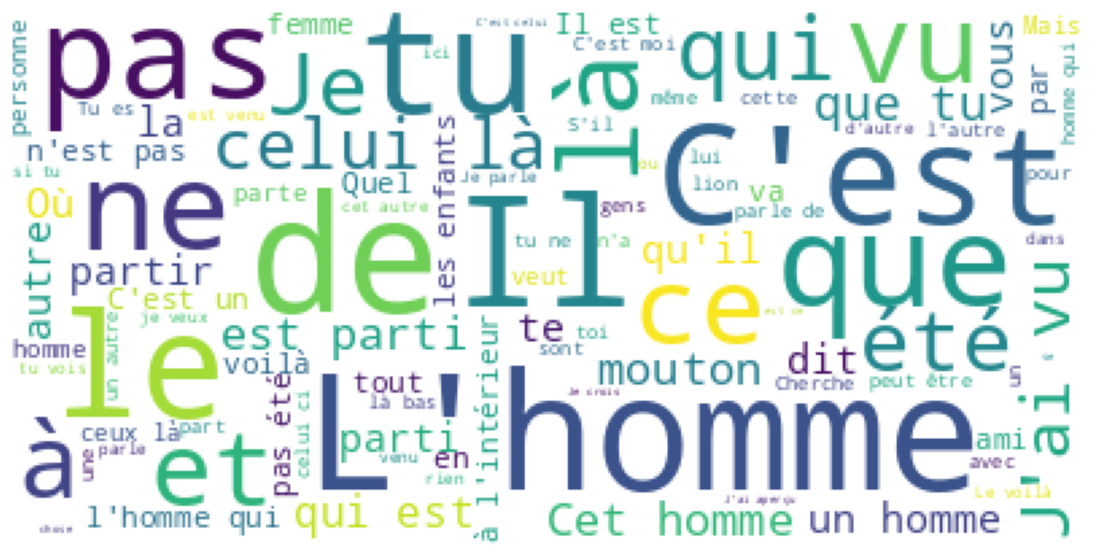



####################################################################################################




In [27]:
french_results = pipeline1.execute_pipeline("nlp_pipeline")

Let us analyze some of the outputs:

- create_corpus: We identified 11485 tokens and 1122 unique tokens in the French corpus. 
- show_most_common_words: The most common words are pronouns, punctuations, attributes, and prepositions, part of stop words. As we specified in the previous sections, they are part of the translation and cannot be removed from the sentences. But they will be investigated later. 
- plot_frequency_histogram: The tokens with a frequency lesser or equal than 8 constitute 83% of the corpus. It is a big issues since a large amount of words appear only on some sentences. Particularly, latter, after splitting the dataset, words (or most of the words) can appear only in the training set and not in the testing and the opposite case is also possible. We will try to generate texts in order to augment the number of sentences and thus obtain more similar tokens. An approach is to used the `nlpaug` library which provide some interesting method for making augmentation.  

- plot_wordcloud: According to the WordCloud, the most common words in the corpus except the stop words are : "L'homme", "Cet homme", "homme", "mouton", "les enfants", "femme", "l'int√©rieur", "est parti", "parti".

Let us recuperate the different results.

In [28]:
tokens, (corpus, corpus_text), (freqs, token_idx) = french_results

The token indices can be used for the machine translation task. Let us show some of them.

In [29]:
pd.Series(token_idx).sample(20)


153          Honore
447           guide
852          soient
638               ¬ª
1058         virent
467              Te
318         lorsque
325            fait
734           Donne
452     travaillais
312              t'
99               tu
662         Demande
242            pour
809         souffre
258           ville
986           Pr√™te
218              te
23               Un
1030         s√©duit
dtype: object

- Wolof corpus: Let us apply the French pipeline to it

In [30]:
# modify the text
pipeline1.corpus = corpora['wolof'].to_list()

Let us execute the pipeline and investigate the results.

Method 1: tokenize_text -> result = True



####################################################################################################


Method 2: create_corpus -> result = True



100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1615/1615 [00:00<00:00, 1614732.05it/s]

Number of words: ------------8309
Number of unique words: ------------1140


####################################################################################################


Method 3: create_frequency -> result = False

       index  frequency
0    Demagul          1
1  Seeteegul          1
2  Wuut√≥ogul          1
3   Gis√©egul          1
4        Nit         72


####################################################################################################


Method 4: show_frequency_out_limits -> result = False

Low limit: -------------3.5
High limit: -------------8.5


####################################################################################################


Method 5: show_most_common_words -> result = False

Most common words are:
('.', '!', '?', 'dem', 'la', ',', 'gi', '≈ãga', 'na', 'G√≥or', 'naa', 'Gis', 'ci', '√±√´w', 'mu', 'wax', 'Nit', 'g√≥or', 'di', 'nit')


###############################################################################################



####################################################################################################


Method 7: show_n_time_frequency_words -> result = False

Percentage of words appearing 1/2/3/4/5/6/7/8 times in the dataset: 0.8508771929824561%
Words appearing 1/2/3/4/5/6/7/8 times:
          index  frequency
0       Demagul          1
1     Seeteegul          1
2     Wuut√≥ogul          1
3      Gis√©egul          1
5         bonul          3
16         sama          8
17          wet          4
18       kookuu          5
22         kale          1
24      kookale          4
25          kee          5
26       kookee          5
29           ju          2
30       Xoolal          3
31         mb√´r          5
34        sarax          1
35           su          8
37       Xamoon          2
38         ja≈ãx          2
42        jooju          2
43   Xammeewoon          2
44         ja≈ãg          1
46         yile          2
47     yaruna√±u          1
49         jale          2
52 

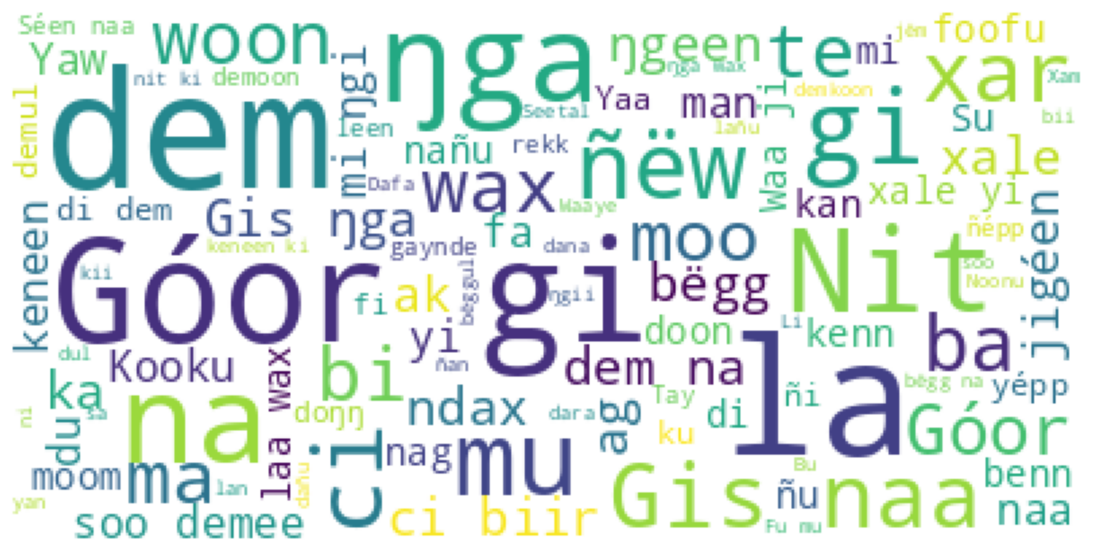



####################################################################################################




In [31]:
wolof_results = pipeline1.execute_pipeline("nlp_pipeline")

Let us analyze some of the outputs:

- create_corpus: We identified 8309 tokens and 1140 unique tokens in the Wolof corpus. 
- show_most_common_words: The most common words are pronouns, punctuations, attributes, and prepositions, part of stop words like for the French corpus.
- plot_frequency_histogram: Like with the French corpus we have a large number of tokens appearing less than 9 times in the corpus. It means that most of them appear only in one sentence or in only few sentences in the corpus. They constitute 85 % of the tokens which is a big part of the total number of tokens. We can make a first data augmentation with the `nlpaug` library.
- plot_wordcloud: According to the WordCloud, the most common words in the corpus except the stop words are : "Goor", "Gis", "dem", "Nit", "new", "begg", "jig√©en", "Xale", "xar", "xale yi". We will guess if it is necessary to remove the most common words latter when testing the translation model. They can add a bias to the model predictions.